In [24]:
latent = np.load("./dataset_release/training_latent/cam16_2/latent_stylegan1.npy")

In [6]:
latent.shape

(19, 512)

In [9]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152

import sys
sys.path.append('..')

import torch
import torch.nn as nn
torch.manual_seed(0)
import json
import pickle
from collections import OrderedDict
import numpy as np
device_ids = [0]
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib

from models.stylegan1 import G_mapping,Truncation,G_synthesis
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'tensorflow'

In [16]:
tflib.init_tf()
with open('./checkpoints/stylegan_pretrain/afhqdog.pkl', 'rb') as f:
    Gm, _D, Gs = pickle.load(f)
G_pkl = OrderedDict([(k, torch.from_numpy(v.value().eval()))
                                           for k, v in Gs.trainables.items()])

ModuleNotFoundError: No module named 'torch_utils.persistence'

In [105]:
for k, v in G_pkl.items():
    print(k, v.shape)

G_synthesis/4x4/Const/const torch.Size([1, 512, 4, 4])
G_synthesis/4x4/Const/Noise/weight torch.Size([512])
G_synthesis/4x4/Const/bias torch.Size([512])
G_synthesis/4x4/Const/StyleMod/weight torch.Size([512, 1024])
G_synthesis/4x4/Const/StyleMod/bias torch.Size([1024])
G_synthesis/4x4/Conv/weight torch.Size([3, 3, 512, 512])
G_synthesis/4x4/Conv/Noise/weight torch.Size([512])
G_synthesis/4x4/Conv/bias torch.Size([512])
G_synthesis/4x4/Conv/StyleMod/weight torch.Size([512, 1024])
G_synthesis/4x4/Conv/StyleMod/bias torch.Size([1024])
G_synthesis/ToRGB_lod6/weight torch.Size([1, 1, 512, 3])
G_synthesis/ToRGB_lod6/bias torch.Size([3])
G_synthesis/8x8/Conv0_up/weight torch.Size([3, 3, 512, 512])
G_synthesis/8x8/Conv0_up/Noise/weight torch.Size([512])
G_synthesis/8x8/Conv0_up/bias torch.Size([512])
G_synthesis/8x8/Conv0_up/StyleMod/weight torch.Size([512, 1024])
G_synthesis/8x8/Conv0_up/StyleMod/bias torch.Size([1024])
G_synthesis/8x8/Conv1/weight torch.Size([3, 3, 512, 512])
G_synthesis/8x8

In [10]:
avg_latent = np.load("./dataset_release/training_latent/cat_16/avg_latent_cat.npy")

g_pt = nn.Sequential(OrderedDict([
            ('g_mapping', G_mapping()),
            ('truncation', Truncation(avg_latent, max_layer=7, device=device, threshold=0.7)),
            ('g_synthesis', G_synthesis( resolution=256))
        ]))
g_pt = g_pt.state_dict()
# for k, v in g_pt.state_dict().items():
#     print(k, v.shape)

In [126]:
def transpose(x, order):
    return torch.from_numpy(x.numpy().transpose(order))

In [127]:
g_pt['g_mapping.dense0.weight'] = transpose(G_pkl['G_mapping/Dense0/weight'], (1, 0))
g_pt['g_mapping.dense0.bias'] = G_pkl['G_mapping/Dense0/bias']
g_pt['g_mapping.dense1.weight'] = transpose(G_pkl['G_mapping/Dense1/weight'], (1, 0))
g_pt['g_mapping.dense1.bias'] = G_pkl['G_mapping/Dense1/bias']
g_pt['g_mapping.dense2.weight'] = transpose(G_pkl['G_mapping/Dense2/weight'], (1, 0))
g_pt['g_mapping.dense2.bias'] = G_pkl['G_mapping/Dense2/bias']
g_pt['g_mapping.dense3.weight'] = transpose(G_pkl['G_mapping/Dense3/weight'], (1, 0))
g_pt['g_mapping.dense3.bias'] = G_pkl['G_mapping/Dense3/bias']
g_pt['g_mapping.dense4.weight'] = transpose(G_pkl['G_mapping/Dense4/weight'], (1, 0))
g_pt['g_mapping.dense4.bias'] = G_pkl['G_mapping/Dense4/bias']
g_pt['g_mapping.dense5.weight'] = transpose(G_pkl['G_mapping/Dense5/weight'], (1, 0))
g_pt['g_mapping.dense5.bias'] = G_pkl['G_mapping/Dense5/bias']
g_pt['g_mapping.dense6.weight'] = transpose(G_pkl['G_mapping/Dense6/weight'], (1, 0))
g_pt['g_mapping.dense6.bias'] = G_pkl['G_mapping/Dense6/bias']
g_pt['g_mapping.dense7.weight'] = transpose(G_pkl['G_mapping/Dense7/weight'], (1, 0))
g_pt['g_mapping.dense7.bias'] = G_pkl['G_mapping/Dense7/bias']

g_pt['g_synthesis.torgb.weight'] = transpose(G_pkl['G_synthesis/ToRGB_lod0/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.torgb.bias'] = G_pkl['G_synthesis/ToRGB_lod0/bias']

g_pt['g_synthesis.blocks.4x4.const'] = G_pkl['G_synthesis/4x4/Const/const']
g_pt['g_synthesis.blocks.4x4.bias'] = G_pkl['G_synthesis/4x4/Const/bias']
g_pt['g_synthesis.blocks.4x4.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/4x4/Const/Noise/weight']
g_pt['g_synthesis.blocks.4x4.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/4x4/Const/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.4x4.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/4x4/Const/StyleMod/bias']
g_pt['g_synthesis.blocks.4x4.conv.weight'] = transpose(G_pkl['G_synthesis/4x4/Conv/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.4x4.conv.bias'] = G_pkl['G_synthesis/4x4/Conv/bias']
g_pt['g_synthesis.blocks.4x4.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/4x4/Conv/Noise/weight']
g_pt['g_synthesis.blocks.4x4.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/4x4/Conv/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.4x4.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/4x4/Conv/StyleMod/bias']

g_pt['g_synthesis.blocks.8x8.conv0_up.weight'] = transpose(G_pkl['G_synthesis/8x8/Conv0_up/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.8x8.conv0_up.bias'] = G_pkl['G_synthesis/8x8/Conv0_up/bias']
g_pt['g_synthesis.blocks.8x8.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/8x8/Conv0_up/Noise/weight']
g_pt['g_synthesis.blocks.8x8.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/8x8/Conv0_up/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.8x8.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/8x8/Conv0_up/StyleMod/bias']
g_pt['g_synthesis.blocks.8x8.conv1.weight'] = transpose(G_pkl['G_synthesis/8x8/Conv1/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.8x8.conv1.bias'] = G_pkl['G_synthesis/8x8/Conv1/bias']
g_pt['g_synthesis.blocks.8x8.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/8x8/Conv1/Noise/weight']
g_pt['g_synthesis.blocks.8x8.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/8x8/Conv1/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.8x8.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/8x8/Conv1/StyleMod/bias']

g_pt['g_synthesis.blocks.16x16.conv0_up.weight'] = transpose(G_pkl['G_synthesis/16x16/Conv0_up/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.16x16.conv0_up.bias'] = G_pkl['G_synthesis/16x16/Conv0_up/bias']
g_pt['g_synthesis.blocks.16x16.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/16x16/Conv0_up/Noise/weight']
g_pt['g_synthesis.blocks.16x16.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/16x16/Conv0_up/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.16x16.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/16x16/Conv0_up/StyleMod/bias']
g_pt['g_synthesis.blocks.16x16.conv1.weight'] = transpose(G_pkl['G_synthesis/16x16/Conv1/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.16x16.conv1.bias'] = G_pkl['G_synthesis/16x16/Conv1/bias']
g_pt['g_synthesis.blocks.16x16.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/16x16/Conv1/Noise/weight']
g_pt['g_synthesis.blocks.16x16.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/16x16/Conv1/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.16x16.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/16x16/Conv1/StyleMod/bias']

g_pt['g_synthesis.blocks.32x32.conv0_up.weight'] = transpose(G_pkl['G_synthesis/32x32/Conv0_up/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.32x32.conv0_up.bias'] = G_pkl['G_synthesis/32x32/Conv0_up/bias']
g_pt['g_synthesis.blocks.32x32.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/32x32/Conv0_up/Noise/weight']
g_pt['g_synthesis.blocks.32x32.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/32x32/Conv0_up/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.32x32.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/32x32/Conv0_up/StyleMod/bias']
g_pt['g_synthesis.blocks.32x32.conv1.weight'] = transpose(G_pkl['G_synthesis/32x32/Conv1/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.32x32.conv1.bias'] = G_pkl['G_synthesis/32x32/Conv1/bias']
g_pt['g_synthesis.blocks.32x32.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/32x32/Conv1/Noise/weight']
g_pt['g_synthesis.blocks.32x32.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/32x32/Conv1/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.32x32.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/32x32/Conv1/StyleMod/bias']

g_pt['g_synthesis.blocks.64x64.conv0_up.weight'] = transpose(G_pkl['G_synthesis/64x64/Conv0_up/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.64x64.conv0_up.bias'] = G_pkl['G_synthesis/64x64/Conv0_up/bias']
g_pt['g_synthesis.blocks.64x64.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/64x64/Conv0_up/Noise/weight']
g_pt['g_synthesis.blocks.64x64.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/64x64/Conv0_up/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.64x64.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/64x64/Conv0_up/StyleMod/bias']
g_pt['g_synthesis.blocks.64x64.conv1.weight'] = transpose(G_pkl['G_synthesis/64x64/Conv1/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.64x64.conv1.bias'] = G_pkl['G_synthesis/64x64/Conv1/bias']
g_pt['g_synthesis.blocks.64x64.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/64x64/Conv1/Noise/weight']
g_pt['g_synthesis.blocks.64x64.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/64x64/Conv1/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.64x64.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/64x64/Conv1/StyleMod/bias']

g_pt['g_synthesis.blocks.128x128.conv0_up.weight'] = transpose(G_pkl['G_synthesis/128x128/Conv0_up/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.128x128.conv0_up.bias'] = G_pkl['G_synthesis/128x128/Conv0_up/bias']
g_pt['g_synthesis.blocks.128x128.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/128x128/Conv0_up/Noise/weight']
g_pt['g_synthesis.blocks.128x128.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/128x128/Conv0_up/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.128x128.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/128x128/Conv0_up/StyleMod/bias']
g_pt['g_synthesis.blocks.128x128.conv1.weight'] = transpose(G_pkl['G_synthesis/128x128/Conv1/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.128x128.conv1.bias'] = G_pkl['G_synthesis/128x128/Conv1/bias']
g_pt['g_synthesis.blocks.128x128.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/128x128/Conv1/Noise/weight']
g_pt['g_synthesis.blocks.128x128.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/128x128/Conv1/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.128x128.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/128x128/Conv1/StyleMod/bias']

g_pt['g_synthesis.blocks.256x256.conv0_up.weight'] = transpose(G_pkl['G_synthesis/256x256/Conv0_up/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.256x256.conv0_up.bias'] = G_pkl['G_synthesis/256x256/Conv0_up/bias']
g_pt['g_synthesis.blocks.256x256.epi1.top_epi.noise.weight'] = G_pkl['G_synthesis/256x256/Conv0_up/Noise/weight']
g_pt['g_synthesis.blocks.256x256.epi1.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/256x256/Conv0_up/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.256x256.epi1.style_mod.lin.bias'] = G_pkl['G_synthesis/256x256/Conv0_up/StyleMod/bias']
g_pt['g_synthesis.blocks.256x256.conv1.weight'] = transpose(G_pkl['G_synthesis/256x256/Conv1/weight'], (3, 2, 0, 1))
g_pt['g_synthesis.blocks.256x256.conv1.bias'] = G_pkl['G_synthesis/256x256/Conv1/bias']
g_pt['g_synthesis.blocks.256x256.epi2.top_epi.noise.weight'] = G_pkl['G_synthesis/256x256/Conv1/Noise/weight']
g_pt['g_synthesis.blocks.256x256.epi2.style_mod.lin.weight'] = transpose(G_pkl['G_synthesis/256x256/Conv1/StyleMod/weight'], (1, 0))
g_pt['g_synthesis.blocks.256x256.epi2.style_mod.lin.bias'] = G_pkl['G_synthesis/256x256/Conv1/StyleMod/bias']



In [129]:
torch.save(g_pt, './checkpoints/stylegan_pretrain/cam16_256x256_sg.pt')

In [6]:
cpt = torch.load('./checkpoints/stylegan_pretrain/cam16_256x256_sg.pt')
for name in cpt.keys():
    print(name, cpt[name].shape)

g_mapping.dense0.weight torch.Size([512, 512])
g_mapping.dense0.bias torch.Size([512])
g_mapping.dense1.weight torch.Size([512, 512])
g_mapping.dense1.bias torch.Size([512])
g_mapping.dense2.weight torch.Size([512, 512])
g_mapping.dense2.bias torch.Size([512])
g_mapping.dense3.weight torch.Size([512, 512])
g_mapping.dense3.bias torch.Size([512])
g_mapping.dense4.weight torch.Size([512, 512])
g_mapping.dense4.bias torch.Size([512])
g_mapping.dense5.weight torch.Size([512, 512])
g_mapping.dense5.bias torch.Size([512])
g_mapping.dense6.weight torch.Size([512, 512])
g_mapping.dense6.bias torch.Size([512])
g_mapping.dense7.weight torch.Size([512, 512])
g_mapping.dense7.bias torch.Size([512])
g_synthesis.torgb.weight torch.Size([3, 64, 1, 1])
g_synthesis.torgb.bias torch.Size([3])
g_synthesis.blocks.4x4.const torch.Size([1, 512, 4, 4])
g_synthesis.blocks.4x4.bias torch.Size([512])
g_synthesis.blocks.4x4.epi1.top_epi.noise.weight torch.Size([512])
g_synthesis.blocks.4x4.epi1.style_mod.lin.wei

In [130]:
g_pt = nn.Sequential(OrderedDict([
            ('g_mapping', G_mapping()),
            ('truncation', Truncation(None, max_layer=7, device=device, threshold=0.7)),
            ('g_synthesis', G_synthesis( resolution=256))
        ]))
g_all.load_state_dict(torch.load('./checkpoints/stylegan_pretrain/cam16_256x256_sg.pt', map_location='cuda'))

<All keys matched successfully>

# label convert

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

In [45]:
label = plt.imread('cam16/image_0_json/label.png')
label = label[:,:,0]
mask = label/np.unique(label)[1]
mask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
labellist = sorted(glob.glob('cam16/test/mask_*_json/label.png'))
for name in labellist:
    label = plt.imread(name)[:,:,0]
    mask = label/np.unique(label)[1]
    idx = name.split('/')[2].split('_')[1]
    
    np.save('cam16/test/mask_{}.npy'.format(idx), mask)
    print('mask for image ', idx, ' saved in ', 'cam16/test/mask_{}.npy'.format(idx))

mask for image  0  saved in  cam16/test/mask_0.npy
mask for image  1  saved in  cam16/test/mask_1.npy


In [26]:
labellist

['cam16/image_0_json/label.png',
 'cam16/image_10_json/label.png',
 'cam16/image_11_json/label.png',
 'cam16/image_12_json/label.png',
 'cam16/image_13_json/label.png',
 'cam16/image_14_json/label.png',
 'cam16/image_15_json/label.png',
 'cam16/image_16_json/label.png',
 'cam16/image_17_json/label.png',
 'cam16/image_18_json/label.png',
 'cam16/image_19_json/label.png',
 'cam16/image_1_json/label.png',
 'cam16/image_2_json/label.png',
 'cam16/image_3_json/label.png',
 'cam16/image_4_json/label.png',
 'cam16/image_5_json/label.png',
 'cam16/image_6_json/label.png',
 'cam16/image_7_json/label.png',
 'cam16/image_8_json/label.png',
 'cam16/image_9_json/label.png']

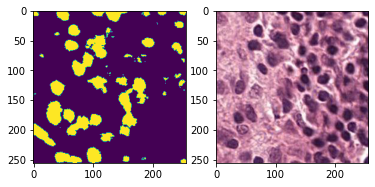

In [23]:
mask = plt.imread('./model_dir/cam16_256/samples/label_0.png')
img = plt.imread('./model_dir/cam16_256/samples/0.png')
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(img)

In [24]:
mask = mask/np.unique(mask)[1]
mask = cv2.merge((mask,mask,mask))

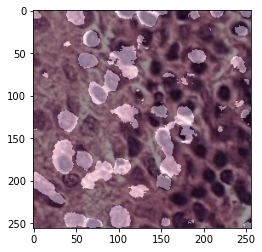

In [28]:
import cv2



merged = cv2.addWeighted(img,0.6,mask,0.4,0)

plt.imshow(merged)